**Note: Please use the [pyEOF](https://pyeof.readthedocs.io/en/latest/installation.html) environment for this script**

This script is used to implement EOF, REOF and k-means clustering to get regions

In [1]:
from pyEOF import *
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gc
import warnings
import pickle
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')

# select region
def sel_extent(ds):
    return ds.sel(lat=slice(6,36),lon=slice(68,98))

# path
ds_path = "./data/daily_surface_pm25_RH50.nc"
mask_path = "./data/land_mask.nc"

## plot the time series of the mean PM2.5 
We decided to use April and August as the testing data

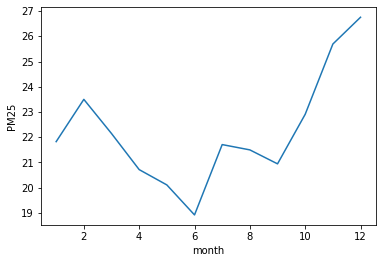

In [2]:
mask = xr.open_dataset(mask_path)
ds = sel_extent(xr.open_dataset(ds_path)).where(mask["mask"])

ds["PM25"].groupby('time.month').mean(dim=["lon","lat","time"]).plot()
plt.show()

## get the data and implement EOFs
Based on the results, we will select 4 PCs (n=4) and implemented varimax rotated EOFs (REOFs)

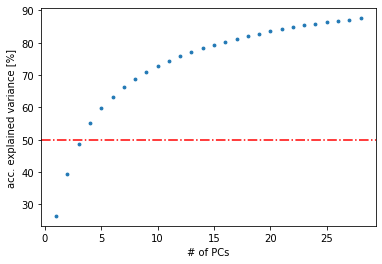

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
n,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000
evf,26.453978,12.957151,9.211833,6.383092,4.698267,3.506565,2.989032,2.459973,2.240435,1.808812,...,0.741121,0.708723,0.657641,0.631714,0.525363,0.506195,0.465119,0.443657,0.423443,0.392263
accum,26.453978,39.411129,48.622959,55.006050,59.704315,63.210880,66.199913,68.659882,70.900322,72.709129,...,82.767487,83.476212,84.133850,84.765564,85.290924,85.797119,86.262238,86.705894,87.129333,87.521599


In [3]:
n=28

# remove months "4" (April) and "8" (August), to be consistant with training data
ds = ds.sel(time=ds.time.dt.month.isin([1,2,3,
                                        5,6,7,
                                        9,10,11,12]))
df = ds["PM25"].to_dataframe().reset_index() # get df from ds

# process the data for implementing pyEOF
df_data = get_time_space(df, time_dim = "time", lumped_space_dims = ["lat","lon"])

# implement PCA/EOF
pca = df_eof(df_data)
eofs = pca.eofs(s=2, n=n)
eofs_ds = eofs.stack(["lat","lon"], dropna=False).to_xarray()
pcs = pca.pcs(s=2, n=n)
evf = pca.evf(n=n)

# show the results
df = pd.DataFrame({"n":np.arange(1,n+1),
                   "evf":pca.evf(n)*100.0,
                   "accum":pca.evf(n).cumsum()*100.0
                  })

plt.scatter(df["n"],df["accum"], s=8)
plt.axhline(y=50,c="r",ls="-.")
plt.xlabel("# of PCs")
plt.ylabel("acc. explained variance [%]")
plt.show()

display(df.transpose())

## implement REOFs

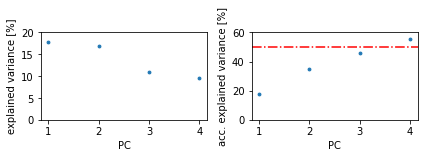

explained variance and acc. explained variance


,0,1,2,3
n,1.000000,2.000000,3.000000,4.000000
evf,17.764507,16.891795,10.944344,9.586945
accum,17.764507,34.656302,45.600647,55.187591


EOFs loading


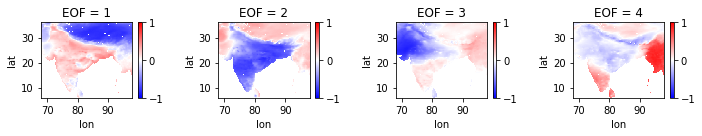

In [4]:
n=4

# implement REOF
pca = df_eof(df_data,pca_type="varimax",n_components=n)
eofs = pca.eofs(s=2, n=n)
eofs_ds = eofs.stack(["lat","lon"], dropna=False).to_xarray()
pcs = pca.pcs(s=2, n=n)
evf = pca.evf(n=n)

df = pd.DataFrame({"n":np.arange(1,n+1),
                   "evf":pca.evf(n)*100.0,
                   "accum":pca.evf(n).cumsum()*100.0
                  })

# show the reults
fig = plt.figure(figsize=(6,2))

ax = fig.add_subplot(121)
ax.scatter(df["n"],df["evf"], s=8)
ax.set_ylim(0,20)
ax.set_ylabel("explained variance [%]")
ax.set_xlabel("PC")

ax = fig.add_subplot(122)
ax.scatter(df["n"],df["accum"], s=8)
ax.set_ylim(0,60)
ax.set_ylabel("acc. explained variance [%]")
ax.set_xlabel("PC")
ax.axhline(y=50,c="r",ls="-.")

plt.tight_layout()
plt.show()

print("explained variance and acc. explained variance")
display(df.transpose())

print("EOFs loading")
eofs.transpose().describe().loc[["max","min"]].transpose()

eofs_ds = eofs.stack(["lat","lon"], dropna=False).to_xarray()
fig = plt.figure(figsize=(10,2))
for i in range(1,n+1):
    ax = fig.add_subplot(1,4,i)
    eofs_ds["PM25"].sel(EOF=i).plot(ax=ax,vmax=1.0,vmin=-1.0,cbar_kwargs={'label': ""},cmap="bwr")
plt.tight_layout()
plt.show()

## weighted EOFs loading

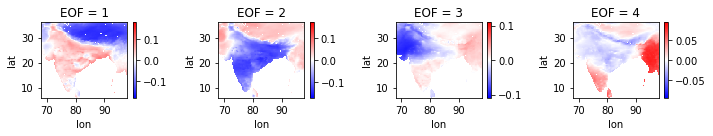

In [5]:
eofs_w = pd.DataFrame(data = (eofs.values * evf.reshape(n,1)),
                      index = eofs.index,
                      columns = eofs.columns)

eofs_w_ds = eofs_w.stack(["lat","lon"], dropna=False).to_xarray()
fig = plt.figure(figsize=(10,2))
for i in range(1,n+1):
    ax = fig.add_subplot(1,4,i)
    eofs_w_ds["PM25"].sel(EOF=i).plot(ax=ax,cmap="bwr",
                                      vmax=1.0*evf[i-1],
                                      vmin=-1.0*evf[i-1],
                                      cbar_kwargs={'label': ""})
plt.tight_layout()
plt.show()

## implement k-Means

In [6]:
# get the index which is not "nan"
placeholder_idx = np.argwhere(~np.isnan((eofs_w.values)[0])).reshape(-1)
# get the matrix without missing values: locations (row) * EOFs (columns)
m = eofs_w.values[:,placeholder_idx].transpose()
# clustering and calculate the Sum_of_squared_distances
Sum_of_squared_distances = []

K = range(2,15)
for n_clusters in tqdm(K):
    kmeans = KMeans(n_clusters=n_clusters, random_state=66).fit(m)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
ssd = Sum_of_squared_distances
residual_x = K[1:]
residual = [(x - y) for x,y in zip(ssd,ssd[1:])]
pd.DataFrame({"n_clusters":K, "ssd":Sum_of_squared_distances}).transpose()

100%|██████████| 13/13 [00:01<00:00,  6.59it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12
n_clusters,2.000000,3.000000,4.000000,5.000000,6.00000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000
ssd,33.348129,20.347439,13.547289,10.998759,8.98673,8.069983,7.194795,6.554066,6.015038,5.550483,5.168633,4.828383,4.557895


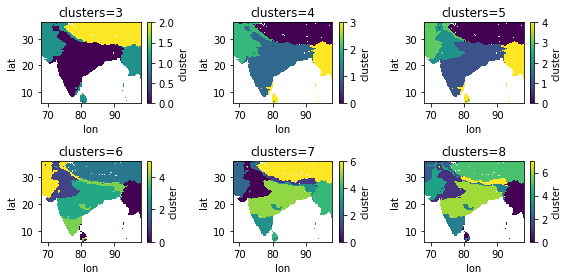

In [7]:
fig = plt.figure(figsize=(8,4))
cluster_list = [3,4,5,6,7,8]
for i in range(len(cluster_list)):
    n_cluster = cluster_list[i]
    ax = fig.add_subplot(2,3,i+1)
    clusters = KMeans(n_clusters=n_cluster, random_state=66).fit_predict(m)

    df_f = eofs.copy()
    df_f.loc[str(n+1),:] = np.nan
    df_f.iloc[n,placeholder_idx] = clusters

    df_fs = df_f.stack(["lat","lon"], dropna=False).to_xarray()
    df_fs.sel(EOF=str(n+1))["PM25"].plot(ax=ax, cbar_kwargs={"label":"cluster"})
    ax.set_title(f"clusters={n_cluster}")
plt.tight_layout()
plt.show()

## we select n_cluster = 6 to further the analysis

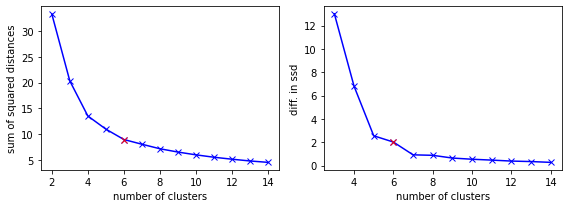

In [8]:
n_cluster = 6

fig = plt.figure(figsize=(8,3))

ax = fig.add_subplot(121)
ax.plot(K, Sum_of_squared_distances, 'bx-')
ax.plot(n_cluster,Sum_of_squared_distances[n_cluster-2],"rx")
ax.set_xlabel('number of clusters')
ax.set_ylabel('sum of squared distances')
# ax.set_title('Elbow method for optimal number of clusters')

ax = fig.add_subplot(122)
ax.plot(residual_x, residual, 'bx-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('diff. in ssd')
ax.plot(n_cluster,residual[n_cluster-3],"rx")
# ax.set_title('difference in sum of squared distances')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

## use n_cluster = 6 to implement the clusters

In [9]:
clusters = KMeans(n_clusters=n_cluster, random_state=66).fit_predict(m)

df_f = eofs.copy()
df_f.loc[str(n+1),:] = np.nan
df_f.iloc[n,placeholder_idx] = clusters

ds_f = df_f.stack(["lat","lon"], dropna=False).to_xarray()

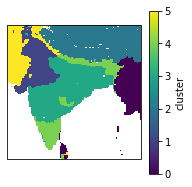

In [10]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([68,98,6,36],crs=ccrs.PlateCarree())
ds_regions = ds_f.sel(EOF=str(n+1))["PM25"].drop("EOF")
ds_regions.plot(ax=ax,cbar_kwargs={"label":"cluster"})
# ax.add_feature(cfeature.STATES.with_scale('10m'),
#                facecolor='none',
#                edgecolor='black')
# ax.add_feature(cfeature.BORDERS,edgecolor='red')
plt.show()

## save the clusters masks

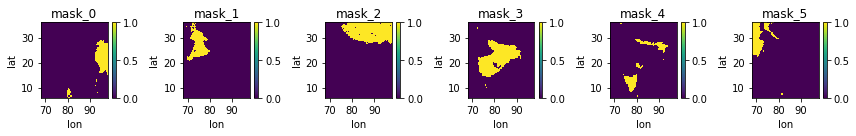

In [11]:
fig = plt.figure(figsize=(2*n_cluster,2))
for i in range(n_cluster):
    ax = fig.add_subplot(1,n_cluster,i+1)
    ds_f["mask_"+str(i)] = ds_regions.where(ds_regions==i).notnull().squeeze()
    ds_f["mask_"+str(i)].plot(ax=ax,cbar_kwargs={"label":""})
    ax.set_title("mask_"+str(i))
plt.tight_layout()
plt.show()

mask_ls = ["mask_"+str(i) for i in range(n_cluster)]
ds_f[mask_ls].to_netcdf("./data/cluster_mask_"+str(n_cluster)+".nc",engine="scipy")

## save the regional masks

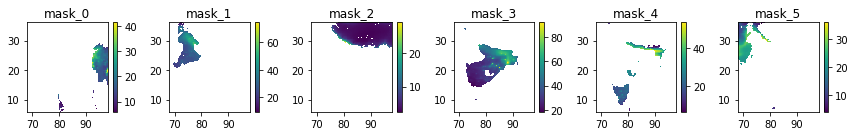

In [12]:
cluster_mask = xr.open_dataset("./data/cluster_mask_"+str(n_cluster)+".nc",engine="scipy")
fig = plt.figure(figsize=(2*n_cluster,2))
for i in range(n_cluster):
    ax = fig.add_subplot(1,n_cluster,i+1)
    ds.mean(dim="time").where(cluster_mask["mask_"+str(i)])["PM25"].plot(ax=ax,cbar_kwargs={"label":""})
    ax.set_title("mask_"+str(i))
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

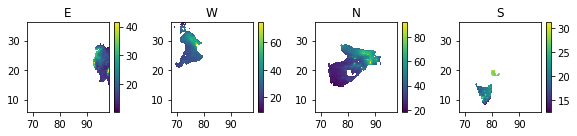

In [13]:
# process
cluster_mask["mask_"+str(0)] = cluster_mask.where((cluster_mask.lon>=90) & (cluster_mask.lat>=15),0)["mask_"+str(0)]
cluster_mask["mask_"+str(3)] = cluster_mask.where((cluster_mask.lat>=12) & (cluster_mask.lat<=30),0)["mask_"+str(3)]
cluster_mask["mask_"+str(4)] = cluster_mask.where((cluster_mask.lat<=20.5) & (cluster_mask.lat>=8),0)["mask_"+str(4)]

# rename
cluster_mask = cluster_mask[["mask_0","mask_1","mask_3","mask_4"]]\
                            .rename({"mask_0":"E","mask_1":"W","mask_3":"N","mask_4":"S"})
loc_name = list(cluster_mask)

fig = plt.figure(figsize=(n_cluster*2,2))
for i in range(len(loc_name)):
    ax = fig.add_subplot(1,n_cluster,i+1)
    ds.mean(dim="time").where(cluster_mask[loc_name[i]])["PM25"].plot(ax=ax,cbar_kwargs={"label":""})
    ax.set_title(loc_name[i])
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

## save and load the regional mask

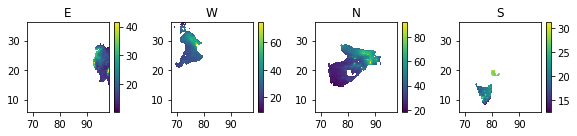

In [14]:
# save the regional mask
cluster_mask.to_netcdf("./data/r_mask.nc",engine="scipy")

# load the regional mask
test = xr.open_dataset("./data/r_mask.nc",engine="scipy")
fig = plt.figure(figsize=(n_cluster*2,2))
for i in range(len(loc_name)):
    ax = fig.add_subplot(1,n_cluster,i+1)
    ds.mean(dim="time").where(test[loc_name[i]])["PM25"].plot(ax=ax,cbar_kwargs={"label":""})
    ax.set_title(loc_name[i])
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()